In [1]:
import pandas as pd
import numpy as np
import dowhy
import warnings
import logging.config

In [2]:
warnings.filterwarnings("ignore")
logging.config.dictConfig({'level': 'INFO', 'version': 1})

In [3]:
raw = pd.read_excel("Bank_Personal_Loan_Modelling.xlsx", sheet_name = "Data", header = 0)

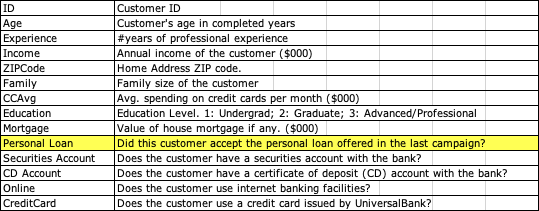

In [4]:
raw

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4996,29,3,40,92697,1,1.9,3,0,0,0,0,1,0
4996,4997,30,4,15,92037,4,0.4,1,85,0,0,0,1,0
4997,4998,63,39,24,93023,2,0.3,3,0,0,0,0,0,0
4998,4999,65,40,49,90034,3,0.5,2,0,0,0,0,1,0


In [5]:
columns = ["Age", "Experience", "Income", "Family", "CCAvg", "Education", "Mortgage", "Personal Loan",
           "Securities Account", "CD Account", "Online", "CreditCard"]
df = raw[columns]

In [6]:
rename = {"Age":"age", "Experience":"experience", "Income":"income", 
          "Family": "family", "CCAvg":"ccavg", "Education":"edu", "Mortgage":"mortgage", 
          "Personal Loan":"personal_loan","Securities Account":"securities_account", 
          "CD Account":"cd_account", "Online":"online", "CreditCard":"credit_card"}

In [7]:
df = df.rename(columns = rename)
df['edu'] = df['edu']>1
df['personal_loan'] = df['personal_loan']>0

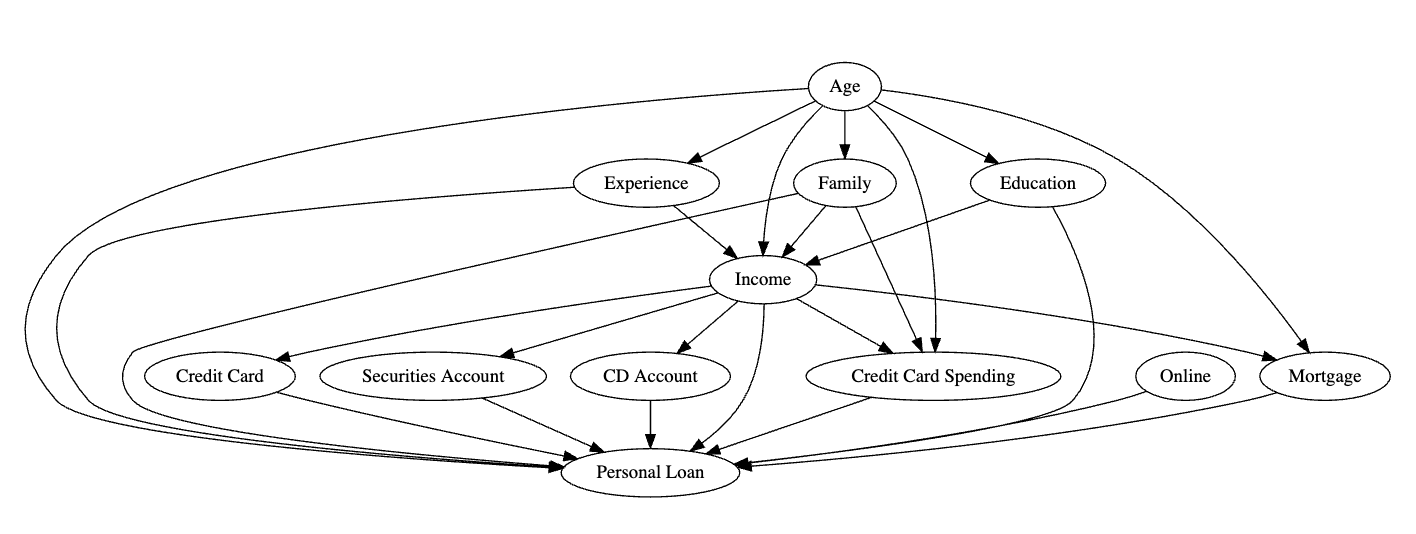

In [8]:
causal_graph = """digraph {
age[label="Age"];
experience[label="Experience"];
income[label="Income"];
family[label="Family"];
ccavg[label="Credit Card Spending"];
edu[label="Education"];
mortgage[label="Mortgage"];
personal_loan[label="Personal Loan"];
securities_account[label="Securities Account"];
cd_account[label="CD Account"];
online[label="Online"];
credit_card[label="Credit Card"];
age -> experience; age -> income; family -> income; age -> ccavg; 
age -> edu; age -> mortgage; age -> personal_loan; age -> family; 
experience -> income; experience -> personal_loan; 
income -> ccavg; income -> mortgage; income -> personal_loan; income -> securities_account;
income -> cd_account; income -> credit_card; 
family -> ccavg; family -> personal_loan;
ccavg -> personal_loan; edu -> personal_loan;
edu -> income; 
mortgage -> personal_loan;
securities_account -> personal_loan; cd_account -> personal_loan; online -> personal_loan;
credit_card -> personal_loan
}"""

In [9]:
### create causal model and visualize causal graph
model= dowhy.CausalModel(
        data = df,
        graph=causal_graph.replace("\n", " "),
        treatment='edu',
        outcome='personal_loan')

In [10]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                                            
──────(Expectation(personal_loan|experience,age,online,family))
d[edu]                                                         
Estimand assumption 1, Unconfoundedness: If U→{edu} and U→personal_loan then P(personal_loan|edu,experience,age,online,family,U) = P(personal_loan|edu,experience,age,online,family)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



In [11]:
estimate = model.estimate_effect(identified_estimand, 
                                 method_name="backdoor.propensity_score_stratification",target_units="ate")
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                                            
──────(Expectation(personal_loan|experience,age,online,family))
d[edu]                                                         
Estimand assumption 1, Unconfoundedness: If U→{edu} and U→personal_loan then P(personal_loan|edu,experience,age,online,family,U) = P(personal_loan|edu,experience,age,online,family)

## Realized estimand
b: personal_loan~edu+experience+age+online+family
Target units: ate

## Estimate
Mean value: 0.09918173302403227



In [12]:
print("ATE without backdoor adjustment:", 
      df[df["edu"] == 1]["personal_loan"].mean() - df[df["edu"] == 0]["personal_loan"].mean())

ATE without backdoor adjustment: 0.08889423380228377


In [13]:
refute1_results=model.refute_estimate(identified_estimand, estimate,
        method_name="random_common_cause")
print(refute1_results)

Refute: Add a Random Common Cause
Estimated effect:0.09918173302403227
New effect:0.09158682254927891



In [14]:
refute2_results=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter")
print(refute2_results)

Refute: Use a Placebo Treatment
Estimated effect:0.09918173302403227
New effect:0.0008726862885628954
p value:0.4



In [15]:
refute3_results=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter")
print(refute3_results)

Refute: Use a subset of data
Estimated effect:0.09918173302403227
New effect:0.09739601602111396
p value:0.33999999999999997

